In [1]:
import pandas as pd


cohort_file = "mak-etal-2017-mixed-2630194534343638755.csv"
cohort = pd.read_csv(cohort_file)

# Remove duplicate subject visits (i.e. only keep baseline visits)
cohort = cohort[cohort["MRI_ID"].str.contains("Baseline")]


In [2]:
import numpy as np

cohort["Study Date"] = pd.to_datetime(cohort["Study Date"])
cohort["Study Date_NX"] = pd.to_datetime(cohort["Study Date_NX"])
cohort["time_diff"] = (cohort["Study Date_NX"] - cohort["Study Date"]) / np.timedelta64(
    1, "D"
)


In [3]:
from pathlib import Path
import re


def get_siena_results(patno: int):
    with Path("outputs", "fsl_siena", str(patno), "report.siena").open() as fin:
        return float(
            re.search("finalPBVC (?P<result>.*) %", fin.read()).groupdict()["result"]
        )


def get_viena_results(patno: int, debug: bool = False):
    with Path("outputs", "fsl_siena", str(patno), "report.viena").open() as fin:
        try:
            return float(
                re.search("finalPVVC (?P<result>.*) %", fin.read()).groupdict()[
                    "result"
                ]
            )
        except:
            if debug:
                print(f"[ERROR]: Cannot retrieve VIENA results for patient: {patno}")
            return None


In [4]:
def pretty_df(df, subset=None, p=0.05, rounding=3):
    def _style(x):
        try:
            if x <= p:
                return "color: red"
            return None
        except Exception:
            return None

    return df.round(rounding).style.applymap(lambda x: _style(x), subset=subset)


# Comparisons of percentage brain volume change and ventricular enlargement


In [5]:
from pingouin import ancova, ttest
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [6]:
# cohort["PATNO"].map(lambda x: get_viena_results(x, debug=True))
cohort["SIENA"] = cohort["PATNO"].map(get_siena_results)
cohort["VIENA"] = cohort["PATNO"].map(get_viena_results)

# Find PD converters and stables
cohort.loc[
    (cohort["COGSTATE"] == 1) & (cohort["COGSTATE_NX"] == 1), "PD_CONVERT"
] = "stable"
cohort.loc[
    (cohort["COGSTATE"] == 1) & (cohort["COGSTATE_NX"] == 2), "PD_CONVERT"
] = "converter"

# Percentage of change for MoCA and UPDRS3
cohort["MOCA_PERC_CHANGE"] = (
    (cohort["MCATOT_NX"] - cohort["MCATOT"])
    / cohort["MCATOT"].abs()
    * 100
    / cohort["time_diff"]
)
cohort["UPDRS3_PERC_CHANGE"] = (
    (cohort["NP3TOT_NX"] - cohort["NP3TOT"])
    / cohort["NP3TOT"].abs()
    * 100
    / cohort["time_diff"]
)


In [7]:
# Exclude patients with failed VIENA preprocessing
from livingpark_utils.ignore import add_ignored

add_ignored(cohort[cohort["VIENA"].isna()], ignore_file=".ppmiignore")


In [8]:
initial_size = len(cohort)
# For now remove subject that failed VIENA preprocessing
cohort = cohort[cohort["VIENA"].notna()]
# Exclude SIENA and VIENA outliers
cohort = cohort[
    (-8 < cohort["SIENA"])
    & (cohort["SIENA"] < 8)
    & (-30 < cohort["VIENA"])
    & (cohort["VIENA"] < 30)
]

print(f"Removed {initial_size - len(cohort)} cohort due to QC.")


Removed 8 cohort due to QC.


In [9]:
cohort.groupby("group").size()


group
hc        35
pd-mci    15
pd-nc     59
dtype: int64

## SIENA (PBVC)


In [10]:
pretty_df(
    ancova(
        data=cohort,
        dv="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "EDUCYRS", "time_diff"],
        between="group",
        effsize="n2",
    ),
    subset="p-unc",
)


,Source,SS,DF,F,p-unc,n2
0,group,2.601000,2,0.447000,0.641000,0.009000
1,AGE_AT_VISIT,1.308000,1,0.449000,0.504000,0.004000
2,SEX,0.015000,1,0.005000,0.943000,0.000000
3,EDUCYRS,0.681000,1,0.234000,0.630000,0.002000
4,time_diff,1.443000,1,0.496000,0.483000,0.005000
5,Residual,297.005000,102,nan,nan,nan


In [11]:
# Account for LEDD
pretty_df(
    ancova(
        data=cohort,
        dv="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "EDUCYRS", "time_diff", "LEDD"],
        between="group",
        effsize="n2",
    ),
    subset="p-unc",
)


,Source,SS,DF,F,p-unc,n2
0,group,0.685000,1,0.287000,0.594000,0.004000
1,AGE_AT_VISIT,3.775000,1,1.582000,0.213000,0.023000
2,SEX,0.065000,1,0.027000,0.870000,0.000000
3,EDUCYRS,0.281000,1,0.118000,0.733000,0.002000
4,time_diff,1.569000,1,0.658000,0.420000,0.009000
5,LEDD,0.586000,1,0.245000,0.622000,0.004000
6,Residual,159.883000,67,nan,nan,nan


In [12]:
tukey = pairwise_tukeyhsd(
    endog=cohort["SIENA"],
    groups=cohort["group"],
    alpha=0.05,
)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    hc pd-mci   0.2588 0.8728 -0.9784 1.4961  False
    hc  pd-nc   0.1796 0.8719 -0.6758  1.035  False
pd-mci  pd-nc  -0.0792 0.9856 -1.2386 1.0801  False
---------------------------------------------------


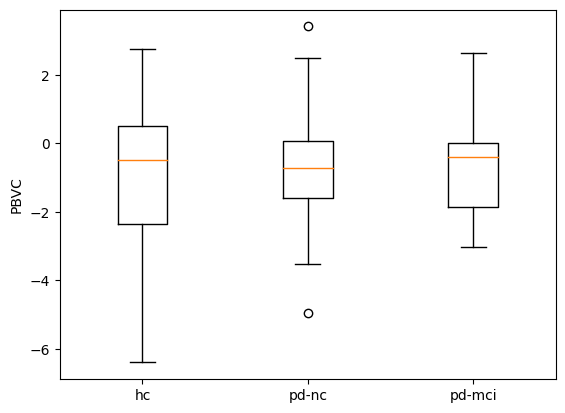

In [13]:
import matplotlib.pyplot as plt
import numpy as np


groups = ["hc", "pd-nc", "pd-mci"]
plt.boxplot([cohort["SIENA"][cohort["group"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("PBVC")

plt.show()


## VIENA (PVVC)


In [14]:
pretty_df(
    ancova(
        data=cohort,
        dv="VIENA",
        covar=["AGE_AT_VISIT", "SEX", "EDUCYRS", "time_diff", "LEDD"],
        between="group",
        effsize="n2",
    ),
    subset="p-unc",
)


,Source,SS,DF,F,p-unc,n2
0,group,25.520000,1,0.501000,0.481000,0.006000
1,AGE_AT_VISIT,42.854000,1,0.842000,0.362000,0.011000
2,SEX,223.401000,1,4.389000,0.040000,0.056000
3,EDUCYRS,134.633000,1,2.645000,0.109000,0.034000
4,time_diff,28.680000,1,0.564000,0.455000,0.007000
5,LEDD,93.388000,1,1.835000,0.180000,0.024000
6,Residual,3409.945000,67,nan,nan,nan


We observe significant $(p < 0.05)$ correlation between PVVC and sex.


In [15]:
cohort.groupby("SEX").size()


SEX
0    42
1    67
dtype: int64

In [16]:
tukey = pairwise_tukeyhsd(endog=cohort["VIENA"], groups=cohort["group"], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    hc pd-mci  -0.9949  0.902 -6.4573 4.4676  False
    hc  pd-nc   0.3359 0.9757 -3.4406 4.1124  False
pd-mci  pd-nc   1.3308 0.8106 -3.7876 6.4491  False
---------------------------------------------------


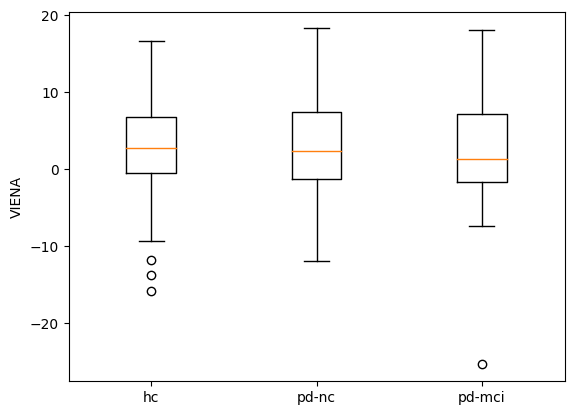

In [17]:
groups = ["hc", "pd-nc", "pd-mci"]
plt.boxplot([cohort["VIENA"][cohort["group"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("VIENA")

plt.show()


## PD converters


In [18]:
cohort.groupby("PD_CONVERT").size()


PD_CONVERT
converter     8
stable       51
dtype: int64

### Whole-brain atrophy


In [19]:
pretty_df(
    ancova(
        data=cohort[cohort["PD_CONVERT"].notna()],
        dv="VIENA",
        covar=["AGE_AT_VISIT", "SEX", "EDUCYRS", "NP3TOT", "PDXDUR", "time_diff"],
        between="PD_CONVERT",
        effsize="n2",
    ),
    subset="p-unc",
)


,Source,SS,DF,F,p-unc,n2
0,PD_CONVERT,0.363000,1,0.010000,0.921000,0.000000
1,AGE_AT_VISIT,38.041000,1,1.045000,0.312000,0.017000
2,SEX,104.936000,1,2.882000,0.096000,0.046000
3,EDUCYRS,212.635000,1,5.841000,0.019000,0.094000
4,NP3TOT,9.749000,1,0.268000,0.607000,0.004000
5,PDXDUR,54.158000,1,1.488000,0.228000,0.024000
6,time_diff,24.807000,1,0.681000,0.413000,0.011000
7,Residual,1820.255000,50,nan,nan,nan


We observe significant $(p < 0.05)$ correlation between $PD_{converter}$ and education years.


In [20]:
pretty_df(
    ttest(
        x=cohort[cohort["PD_CONVERT"] == "stable"]["SIENA"],
        y=cohort[cohort["PD_CONVERT"] == "converter"]["SIENA"],
    ),
    subset="p-val",
)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.144000,8.287000,two-sided,0.889000,[-1.78 1.57],0.068000,0.357,0.054000


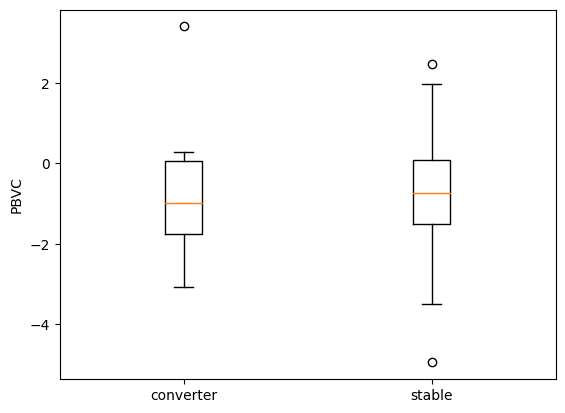

In [21]:
groups = ["converter", "stable"]
plt.boxplot([cohort["SIENA"][cohort["PD_CONVERT"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("PBVC")

plt.show()


### Ventricular enlargement


In [22]:
pretty_df(
    ancova(
        data=cohort[cohort["PD_CONVERT"].notna()],
        dv="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "EDUCYRS", "NP3TOT", "PDXDUR", "time_diff"],
        between="PD_CONVERT",
        effsize="n2",
    ),
    subset="p-unc",
)


,Source,SS,DF,F,p-unc,n2
0,PD_CONVERT,0.690000,1,0.322000,0.573000,0.006000
1,AGE_AT_VISIT,4.106000,1,1.915000,0.173000,0.035000
2,SEX,0.058000,1,0.027000,0.870000,0.000000
3,EDUCYRS,1.133000,1,0.528000,0.471000,0.010000
4,NP3TOT,1.967000,1,0.917000,0.343000,0.017000
5,PDXDUR,0.247000,1,0.115000,0.736000,0.002000
6,time_diff,3.553000,1,1.657000,0.204000,0.030000
7,Residual,107.229000,50,nan,nan,nan


In [23]:
pretty_df(
    ttest(
        x=cohort[cohort["PD_CONVERT"] == "stable"]["VIENA"],
        y=cohort[cohort["PD_CONVERT"] == "converter"]["VIENA"],
    ),
    subset="p-val",
)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.803000,10.459000,two-sided,0.440000,[-6.72 3.14],0.267000,0.45,0.106000


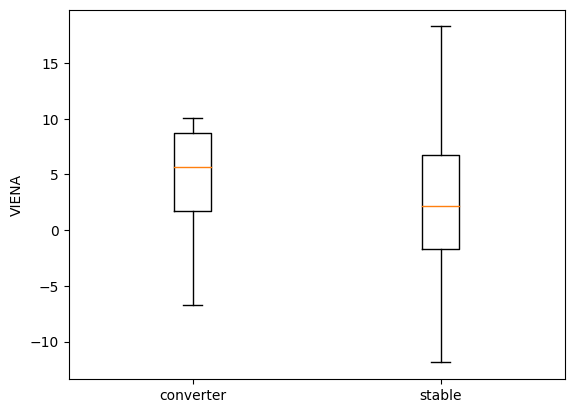

In [24]:
groups = ["converter", "stable"]
plt.boxplot([cohort["VIENA"][cohort["PD_CONVERT"] == g] for g in groups])
plt.xticks(np.arange(len(groups)) + 1, groups)
plt.ylabel("VIENA")

plt.show()


# Correlations of imaging outcome measures with clinical and cognitive functions


In [25]:
from pingouin import partial_corr


## PBVC


### MoCA


In [26]:
pretty_df(
    cohort[cohort["COHORT"] == 1][
        [
            "SIENA",
            "MCATOT",
            "MCATOT_NX",
            "MOCA_PERC_CHANGE",
            "AGE_AT_VISIT",
            "SEX",
            "LEDD",
            "time_diff",
        ]
    ]
    .pcorr()
    .abs()
)


,SIENA,MCATOT,MCATOT_NX,MOCA_PERC_CHANGE,AGE_AT_VISIT,SEX,LEDD,time_diff
SIENA,1.000000,0.098000,0.043000,0.060000,0.197000,0.049000,0.060000,0.076000
MCATOT,0.098000,1.000000,0.951000,0.936000,0.016000,0.223000,0.055000,0.070000
MCATOT_NX,0.043000,0.951000,1.000000,0.939000,0.143000,0.126000,0.043000,0.023000
MOCA_PERC_CHANGE,0.060000,0.936000,0.939000,1.000000,0.117000,0.095000,0.088000,0.023000
AGE_AT_VISIT,0.197000,0.016000,0.143000,0.117000,1.000000,0.027000,0.125000,0.080000
SEX,0.049000,0.223000,0.126000,0.095000,0.027000,1.000000,0.230000,0.039000
LEDD,0.060000,0.055000,0.043000,0.088000,0.125000,0.230000,1.000000,0.237000
time_diff,0.076000,0.070000,0.023000,0.023000,0.080000,0.039000,0.237000,1.000000


The cell colored in red have significant correlation $(p < 0.05)$


In [27]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="MCATOT",
        y="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,73,-0.183000,[-0.4 0.06],0.131000


In [28]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="MCATOT_NX",
        y="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,74,-0.138000,[-0.36 0.1 ],0.256000


In [29]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="MOCA_PERC_CHANGE",
        y="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,73,0.024000,[-0.21 0.26],0.845000


### UPDRS3


In [30]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="NP3TOT",
        y="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,73,0.142000,[-0.1 0.37],0.243000


In [31]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="NP3TOT_NX",
        y="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,74,0.180000,[-0.06 0.4 ],0.135000


In [32]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="UPDRS3_PERC_CHANGE",
        y="SIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,73,-0.014000,[-0.25 0.22],0.908000


## Ventricular enlargement


In [33]:
pretty_df(
    cohort[cohort["COHORT"] == 1][
        [
            "VIENA",
            "MCATOT",
            "MCATOT_NX",
            "MOCA_PERC_CHANGE",
            "AGE_AT_VISIT",
            "SEX",
            "LEDD",
            "time_diff",
        ]
    ]
    .pcorr()
    .abs()
)


,VIENA,MCATOT,MCATOT_NX,MOCA_PERC_CHANGE,AGE_AT_VISIT,SEX,LEDD,time_diff
VIENA,1.000000,0.170000,0.188000,0.107000,0.090000,0.271000,0.193000,0.122000
MCATOT,0.170000,1.000000,0.953000,0.936000,0.021000,0.254000,0.015000,0.055000
MCATOT_NX,0.188000,0.953000,1.000000,0.937000,0.134000,0.168000,0.003000,0.003000
MOCA_PERC_CHANGE,0.107000,0.936000,0.937000,1.000000,0.120000,0.117000,0.061000,0.014000
AGE_AT_VISIT,0.090000,0.021000,0.134000,0.120000,1.000000,0.012000,0.154000,0.085000
SEX,0.271000,0.254000,0.168000,0.117000,0.012000,1.000000,0.273000,0.008000
LEDD,0.193000,0.015000,0.003000,0.061000,0.154000,0.273000,1.000000,0.260000
time_diff,0.122000,0.055000,0.003000,0.014000,0.085000,0.008000,0.260000,1.000000


The cell colored in red have significant correlation $(p < 0.05)$


### MoCA


In [34]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="MCATOT",
        y="VIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,73,0.062000,[-0.18 0.29],0.615000


In [35]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="MCATOT_NX",
        y="VIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,74,-0.167000,[-0.39 0.07],0.167000


In [36]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="MOCA_PERC_CHANGE",
        y="VIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,73,-0.208000,[-0.42 0.03],0.087000


### UPDRS3


In [37]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="NP3TOT",
        y="VIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,73,0.020000,[-0.22 0.26],0.869000


In [38]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="NP3TOT_NX",
        y="VIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,74,0.029000,[-0.21 0.26],0.809000


In [39]:
pretty_df(
    partial_corr(
        data=cohort[cohort["COHORT"] == 1],
        x="UPDRS3_PERC_CHANGE",
        y="VIENA",
        covar=["AGE_AT_VISIT", "SEX", "LEDD", "time_diff"],
    ),
    subset="p-val",
)


,n,r,CI95%,p-val
pearson,73,-0.021000,[-0.26 0.22],0.867000
